## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [ ]:
import sys
import os.path
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt

### Importing our own code
We also need to tell Python where to look to find our own code.  It has a list of directories that it looks in, but our little project isn't in that list, unless we add it -- which is what `sys.path.append()` does.  You'll need to change this path to reflect where on your computer the PUDL project folder (which you pull down with `git`) lives.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in the `ferc1` and `pudl` modules from the `pudl` package (which is a directory inside the `pudl` project directory).

In [ ]:
sys.path.append('/Users/christinagosnell/code/pudl')
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
sys.path.append('/Users/Nannerz/Desktop/working/pudl/')
sys.path.append('/home/alana/Dropbox/catalyst/pudl')
from pudl import ferc1, pudl, models, models_ferc1, settings, constants

### Automatically reloading a work in progress
Because you're probably going to be editing the Python modules related to PUDL while you're working with this notebook, it's useful to have them get automatically reloaded before every cell is executed -- this means you're always using the freshest version of the module, with all your recent edits.

In [ ]:
%load_ext autoreload
%autoreload 1
%aimport pudl.pudl
%aimport pudl.ferc1
%aimport pudl.constants
%aimport pudl.settings
%aimport pudl.models

### Connecting to our databases.
We have two different databases that we're working with right now.  The FERC Form 1 (`ferc1`) and our own PUDL database (`pudl`). For this software to work, you'll need to have the Postgresql database server running on your computer, and you'll need to have created empty databases to receive the tables and data we're going to create.  On a mac, the easiest Postgres install to get running is probably Postgress.app.  You'll need to fire it up at the command line at least once to create the databases (one called `ferc1` and another called `pudl_sandbox`) and a user named `catalyst` with no password.  This information is stored in the `settings` module if you need to look it up.

Here are two shortcuts for connecting to the two databases once they're created:

In [ ]:
pudl_engine  = pudl.pudl.db_connect_pudl()
ferc1_engine = pudl.ferc1.db_connect_ferc1()

### Initializing the FERC Form 1 database
Now that you've got an empty database, let's put some data in it!  This function initializes the database by reading in the FERC Form 1 database structure from `refyear` and data from `years` (which can eventually be a list of years, but that's not working yet...). In order for this to work, you need to have the FERC Form 1 data downloaded into the data directory. There's a script called `get_ferc1.sh` down in `data/ferc/form1/` that will get it for you if you don't have it.

In [ ]:
pudl.ferc1.init_db(refyear=2015, years=[2007,2008,2009,2010,2011,2012,2013,2014,2015], ferc1_tables=pudl.constants.ferc1_default_tables)

### Initializing the PUDL database
We'll pull in FERC 1 fuel, FERC 1 steam, and EIA 923's Fuel Receipts and Costs and generation fuel

In [ ]:
pudl.pudl.init_db(ferc1_tables=['f1_fuel','f1_steam'], ferc1_years=[2007,2008,2009,2010,2011,2012,2013,2014,2015],\
                                  eia923_tables=['fuel_receipts_costs_eia923','generation_fuel_eia923'], eia923_years=[2011,2012,2013,2014,2015], debug=True)

## Define a function to clean data frames
First, let's pull in the applicable data from the PUDL FERC tables.

In [ ]:
# First, let's pull in the applicable data from the PUDL FERC tables:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

Then, we'll define a function that takes as arguments: 

- a series of data to clean
- minimum and maximum values (ints) which bound the reasonable range of values for the series
- multipliers (list) by which to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [ ]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

We'll next define a function to show us graphs of what the data looks like before and after it is cleaned, and to show us how much data the cleaning process was not able to clean. This function will take 5 arguments:

- a series of data to be cleaned
- a series of data which has been cleaned by the cleaning function
- the title (string) to apply to the before and after graphs
- the x label (string) to apply to the before and after graphs
- the y label (string) to apply to the before and after graphs

The function will returned the before and after graphs and the percentage of how many values were not cleaned and were instead set to NaN.

In [ ]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    
    fig_1 = plt.figure(figsize=(14,10))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.show()
    
    na_percentage =  ( fixed.isnull().sum() / len(fixed) ) * 100
    
    return(fig_1, na_percentage)

### FERC Form 1 Average heat content
Let's use these two functions to clean the average heat content of Form 1 coal and gas data, respectively.

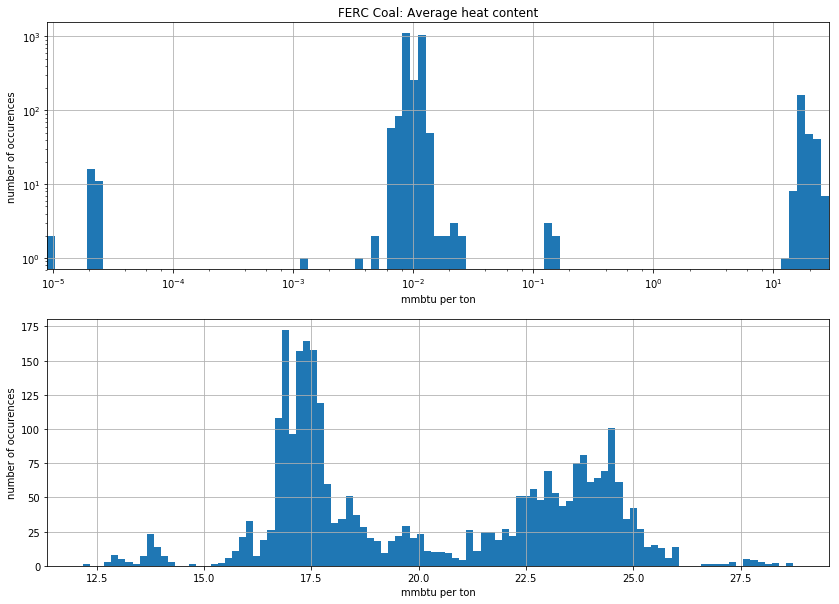

(<matplotlib.figure.Figure at 0x143d2bf60>, 2.2574123989218329)

In [295]:
to_fix_avg_heat_content_coal = coal.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_coal = fixit(coal.fuel_avg_mmbtu_per_unit,10,30,[2000,1e6,2000e6])

showfix(to_fix_avg_heat_content_coal,fixed_avg_heat_content_coal,'FERC Coal: Average heat content',\
        'mmbtu per ton','number of occurences')

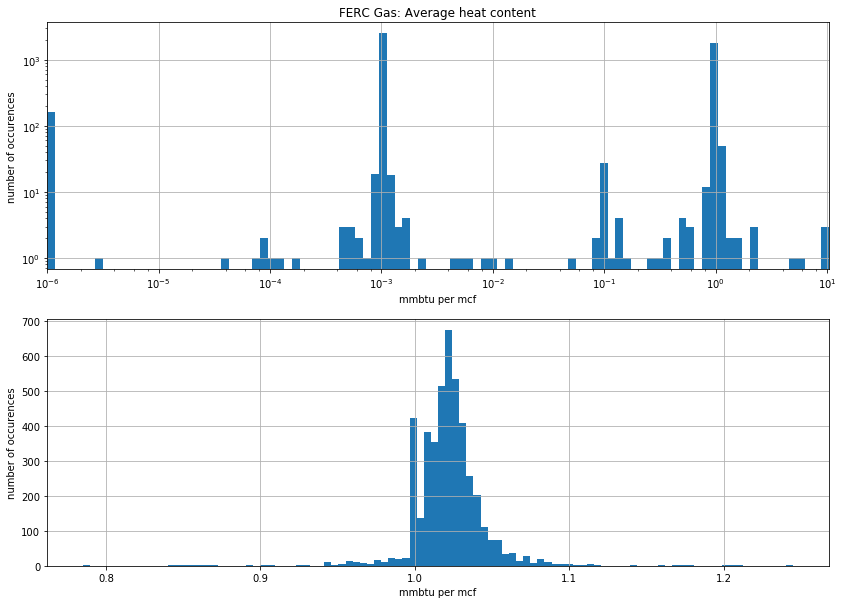

(<matplotlib.figure.Figure at 0x15515fc88>, 3.2569102206985217)

In [296]:
to_fix_avg_heat_content_gas = gas.fuel_avg_mmbtu_per_unit
fixed_avg_heat_content_gas = fixit(gas.fuel_avg_mmbtu_per_unit,.75,1.25,[1000,1e6])

showfix(to_fix_avg_heat_content_gas,fixed_avg_heat_content_gas,'FERC Gas: Average heat content',\
        'mmbtu per mcf','number of occurences')

### FERC Form 1 Cost per mmbtu
Let's use these two functions to clean the cost per mmbtu of Form 1 coal and gas data, respectively.

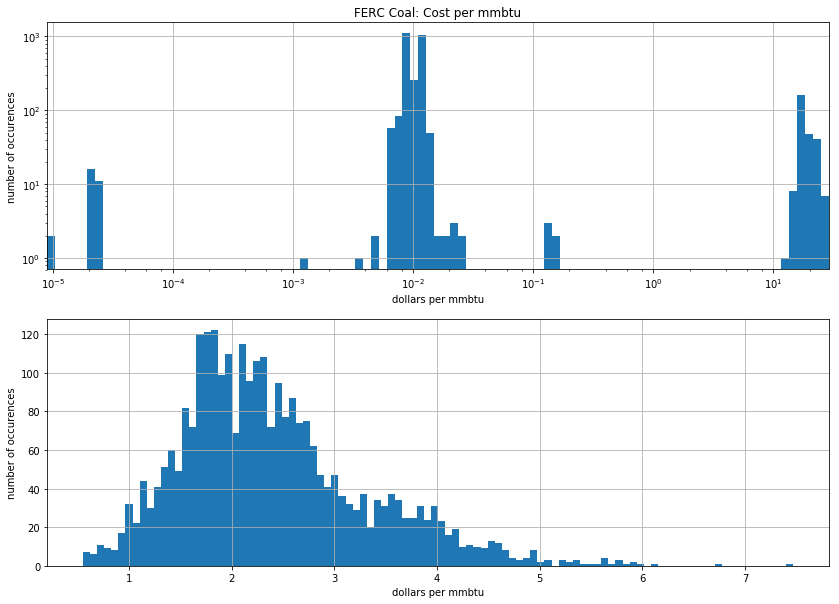

(<matplotlib.figure.Figure at 0x154fa3978>, 2.5943396226415096)

In [294]:
to_fix_cost_per_mmbtu_coal = coal.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_coal = fixit(coal.fuel_cost_per_mmbtu,.5,7.5,[.01,2000])

showfix(to_fix_avg_heat_content_coal,fixed_cost_per_mmbtu_coal,'FERC Coal: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

In [ ]:
to_fix_cost_per_mmbtu_gas = gas.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_gas = fixit(gas.fuel_cost_per_mmbtu,2.5,17.5,[.01,1000,10])

showfix(to_fix_avg_heat_content_gas,fixed_cost_per_mmbtu_gas,'FERC Gas: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

### Heat rate (mmbtu per kWh or MWh) in both EIA 923 and FERC Form 1
We'll start with looking at the range of heat rates in EIA 923 and use those values to clean the heat rate data from FERC Form 1. First we'll select the data from EIA 923 and calculate the heat rate.

In [ ]:
## Select the Generation Fuel table from EIA 923
mwh_eia923 = pd.read_sql('''SELECT * FROM generation_fuel_eia923''', pudl_engine)

In [ ]:
## Add a column for the year in order to get annual heat rate data
mwh_eia923['year'] = pd.DatetimeIndex(mwh_eia923['report_date']).year

In [ ]:
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

In [ ]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1000000)/(mwh_eia923['net_generation_mwh_sum']*1000))

### Analyzing the EIA 923 heat rate data
Let's look at the quantiles and histograms for heat rate data from EIA 923 for coal and gas respectively.

In [ ]:
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]

In [ ]:
mwh_eia923_coal.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

In [ ]:
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]

In [ ]:
mwh_eia923_gas.calculated_heat_rate_btu_per_kwh.quantile(q=[.01,.05,.95,.99])

In [ ]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

### FERC Heat rates
Let's take a look at the FERC Form 1 heat rate data for coal and gas, respectively. For each data set, we'll begin by removing the values at or below zero. 

In [ ]:
coal_above_zero = coal[coal.fuel_mmbtu_per_mwh > 0]
gas_above_zero = gas[gas.fuel_mmbtu_per_mwh > 0]

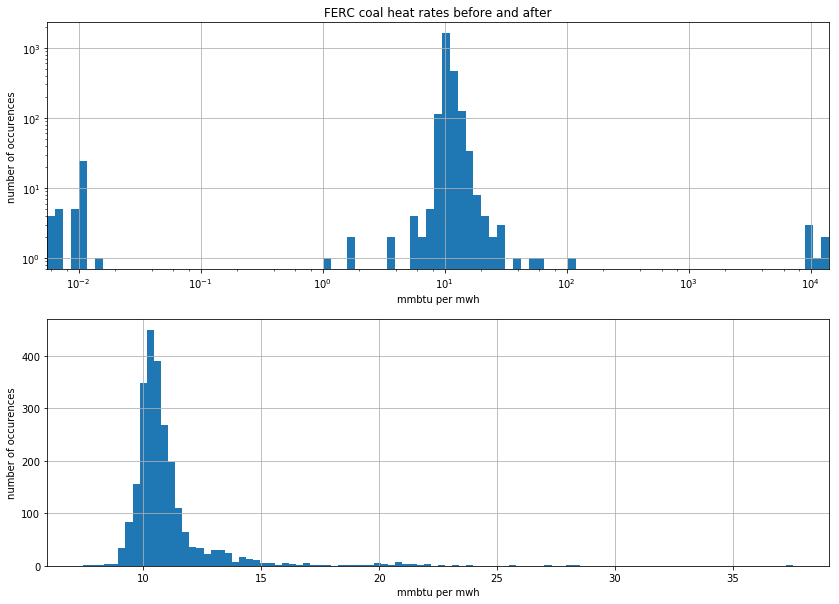

(<matplotlib.figure.Figure at 0x150294898>, 0.61830173124484744)

In [315]:
coal_fix = fixit(coal_above_zero.fuel_mmbtu_per_mwh,7.195,46.922,[2000,.001])
showfix(coal.fuel_mmbtu_per_mwh,coal_fix,'FERC coal heat rates before and after','mmbtu per mwh','number of occurences')

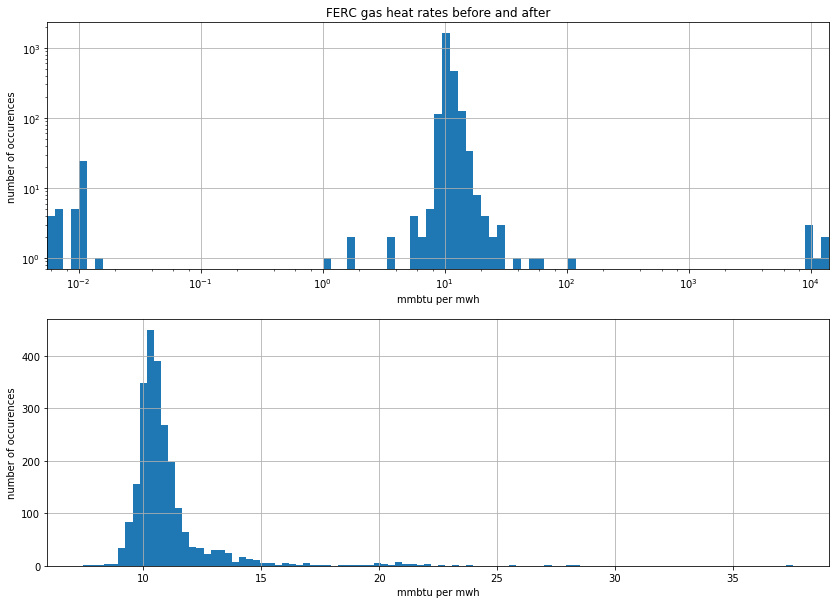

(<matplotlib.figure.Figure at 0x15600cda0>, 0.61830173124484744)

In [316]:
gas_fix = fixit(gas_above_zero.fuel_mmbtu_per_mwh,1.173,52.207,[2000,.001])
showfix(coal.fuel_mmbtu_per_mwh,coal_fix,'FERC gas heat rates before and after','mmbtu per mwh','number of occurences')

### FERC Cost per unit delivered
Let's take a look at histograms and quantiles FERC Form 1 cost per unit delivered for coal and gas, respectively. We'll again remove values at or below zero. This data looks quite clean as it is. 

In [275]:
to_fix_coal_cost_delivered = coal[coal.fuel_cost_per_unit_delivered > 0]
to_fix_gas_cost_delivered = gas[gas.fuel_cost_per_unit_delivered > 0]

In [268]:
to_fix_coal_cost_delivered.fuel_cost_per_unit_delivered.quantile(q=[.01,.05,.5,.95,.99])

0.01     11.6000
0.05     18.5800
0.50     42.7150
0.95     99.6900
0.99    125.5026
Name: fuel_cost_per_unit_delivered, dtype: float64

In [269]:
to_fix_gas_cost_delivered.fuel_cost_per_unit_delivered.quantile(q=[.01,.05,.5,.95,.99])

0.01     1.51792
0.05     3.02940
0.50     5.67000
0.95    14.81920
0.99    50.46196
Name: fuel_cost_per_unit_delivered, dtype: float64

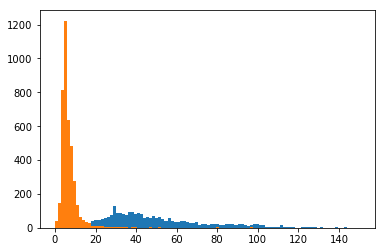

In [267]:
plt.hist(to_fix_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,150))
plt.hist(to_fix_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,150))
plt.show()

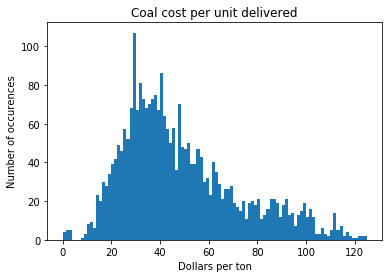

In [270]:
plt.hist(to_fix_coal_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,125))
plt.title('Coal cost per unit delivered')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

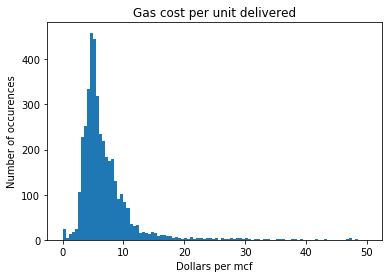

In [271]:
plt.hist(to_fix_gas_cost_delivered.fuel_cost_per_unit_delivered, bins=100,range=(0,50))
plt.title('Gas cost per unit delivered')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()

Looking at the highest and lowest values for each dataset, it appears that there are a handful of values on either end of each data set that are off by a factor of 10 or 100 as well as a few that are off by a factor of 1000. 

In [ ]:
to_fix_coal_cost_delivered.nsmallest(20,'fuel_cost_per_unit_delivered')

In [ ]:
to_fix_coal_cost_delivered.nlargest(50,'fuel_cost_per_unit_delivered')

In [ ]:
to_fix_gas_cost_delivered.nsmallest(50,'fuel_cost_per_unit_delivered')

In [ ]:
to_fix_gas_cost_delivered.nlargest(20,'fuel_cost_per_unit_delivered')

### FERC  Cost per unit burned
Let's take a look at histograms and quantiles FERC Form 1 cost per unit burned for coal and gas, respectively. We'll again remove values at or below zero. This data looks quite clean as it is. 

In [273]:
to_fix_coal_cost_burned = coal[coal.fuel_cost_per_unit_burned > 0]
to_fix_gas_cost_burned = gas[gas.fuel_cost_per_unit_burned > 0]

In [276]:
to_fix_coal_cost_burned.fuel_cost_per_unit_burned.quantile(q=[.01,.05,.5,.95,.99])

0.01     11.67106
0.05     19.08690
0.50     43.10000
0.95    100.51350
0.99    130.09643
Name: fuel_cost_per_unit_burned, dtype: float64

In [277]:
to_fix_gas_cost_burned.fuel_cost_per_unit_burned.quantile(q=[.01,.05,.5,.95,.99])

0.01     1.693
0.05     3.100
0.50     5.826
0.95    15.270
0.99    52.301
Name: fuel_cost_per_unit_burned, dtype: float64

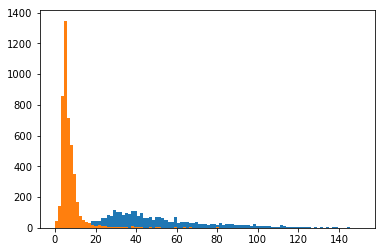

In [274]:
plt.hist(to_fix_coal_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,150))
plt.hist(to_fix_gas_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,150))
plt.show()

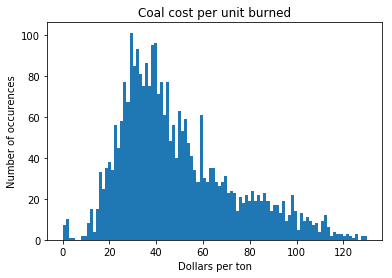

In [278]:
plt.hist(to_fix_coal_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,130))
plt.title('Coal cost per unit burned')
plt.xlabel('Dollars per ton')
plt.ylabel('Number of occurences')
plt.show()

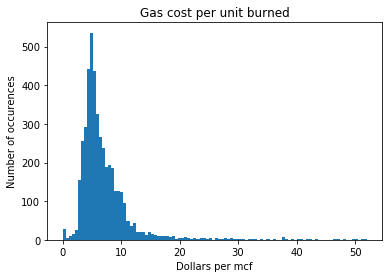

In [280]:
plt.hist(to_fix_gas_cost_burned.fuel_cost_per_unit_burned, bins=100,range=(0,52))
plt.title('Gas cost per unit burned')
plt.xlabel('Dollars per mcf')
plt.ylabel('Number of occurences')
plt.show()